In [5]:
import sys
import pathlib
import os
from nltk.stem.snowball import SpanishStemmer
import re

In [6]:
MIN_LENGTH = 2
MAX_LENGTH = 25
stemming_enabled = True
in_file = "quijote.txt"
palabras_vacias = []

Definimos algunas funciones para normalizar las cadenas. Tomamos como base los programas anteriores, eliminando signos de puntuación, tildes y pasando a minúsculas.  

In [7]:
def remove_punctuation(token):
    return re.sub("\W", "", token)

def translate(to_translate):
    tabin = u'áäâàãéëèêẽíïĩìîóõöòôúüùûũ'
    tabout = u'aaaaaeeeeeiiiiiooooouuuuu'
    tabin = [ord(char) for char in tabin]
    translate_table = dict(zip(tabin, tabout))
    return to_translate.translate(translate_table)

def normalize(token):
    result = token.lower()
    result = translate(result)       
    return result

In [8]:
frequencies = {}
total_tokens  = 0
total_terms = 0

if stemming_enabled:
    stemmer = SpanishStemmer()

with open(in_file, "r", encoding="utf-8") as f:
    for line in f.readlines():
        tokens_list = [remove_punctuation(normalize(x)) for x in line.strip().split()]

        for token in tokens_list:                                     
            total_tokens += 1
            if token not in palabras_vacias and len(token) >= MIN_LENGTH and len(token) <= MAX_LENGTH:
                if stemming_enabled:
                    token = stemmer.stem(token)
                if token in frequencies.keys():
                    frequencies[token] += 1
                else: # Si es la primera vez que veo este token, se agrega a los términos en 1
                    frequencies[token] = 1         
                    total_terms += 1                    

In [9]:
sorted_dict = dict(sorted(frequencies.items(), key=lambda item: item[1], reverse=True))

Dentro de un diccionario almacenamos los términos y la fecuencia de cada uno. Luego lo ordenamos de mayor a menor por la misma.

A continuación, hacemos una transformación a escala logarítmica y calculamos una recta de ajuste:

Ahora mantenemos la escala original, y calculamos una curva de ajuste para esta. 

In [10]:
import numpy as np

x = list(range(1,len(sorted_dict)+1))
y = list(sorted_dict.values())

x_log = np.log(x)
y_log = np.log(y)

In [11]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*(x**b)

popt, pcov = curve_fit(func, x, y)
y_pred = func(x, *popt)

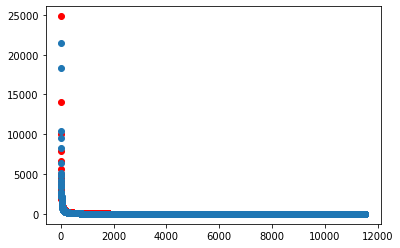

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x, y_pred, color="red")
plt.scatter(x,y)
plt.show()

In [14]:
import pandas as pd

predicted_df = pd.DataFrame({'x':x, 'y':y_pred})
real_df = pd.DataFrame({'x':x, 'y':y}) 

In [41]:
predicted_10000 = len(predicted_df[predicted_df["y"] >= 10000])/len(predicted_df)
predicted_1000 = len(predicted_df[predicted_df["y"] >= 1000])/len(predicted_df)
predicted_100 = len(predicted_df[predicted_df["y"] >= 100])/len(predicted_df)

print(predicted_10000)
print(predicted_1000)
print(predicted_100)

0.00026016824212991065
0.004336137368831845
0.07163298933310207


In [44]:
real_10000 = len(real_df[real_df["y"] >= 10000])/len(real_df)
real_1000 = len(real_df[real_df["y"] >= 1000])/len(real_df)
real_100 = len(real_df[real_df["y"] >= 100])/len(real_df)

print(real_10000)
print(real_1000)
print(real_100)

0.00026016824212991065
0.00416269187407857
0.04101985950914925


Como podemos observar, los resultados no son tan distintos entre la predicción y la realidad. Estos valores demuestran efectivamente lo que propone la Ley de Zipf, y es que hay unos pocos valores que ocurren muchas veces (menos del 4% si consideramos 100 como referencia), y muchos valores que ocurren pocas veces (menos de 100 veces). De hecho, la predicción es más generosa que la realidad, dado que en esta solo el 4% de los términos están más de 100 veces (incluso cuando la frecuencia 100 es 20 veces menor que la mayor). 

A su vez, podemos ver la relación de crecimiento en la cantidad de términos conforme decrece la frecuencia: disminuyendo de f=10000 a f=1000 (reducción por 10), el aumento de términos es de aproximamente 16 veces. Luego, volvemos a reducir por 10 (o 100 sobre el original), y la frecuencia aumenta ~10 veces 